<h1><center> Coastal Low-Level Jet analysis  </center></h1>
<div style="text-align: center"> 
    Dr. Harish Baki <br/> Postdoctoral researcher <br/> TU Delft, Netherlands <br/> Email: h.baki@tudelft.nl<br/>
</div>

In [125]:
import datetime
print(f'Updated: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

Updated: 2024-06-04 10:10:58


In [126]:
import xarray as xr
from netCDF4 import Dataset
import os
import glob
import dask.distributed as dd
import dask
import dask.array as da
import time
import sys
import calendar
from datetime import datetime, timedelta
import numpy as np
import wrf
from itertools import product

import wrf
from wrf import interplevel

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['text.usetex'] = False

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import HourLocator, DateFormatter, MinuteLocator

import cartopy
from cartopy import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from windrose import WindroseAxes

from scipy.stats import weibull_min

import seaborn as sns
import seaborn.objects as so

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator

from scipy.stats import linregress


from meteostat import Stations
from datetime import datetime
from meteostat import Hourly

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as R2

import wrf
from wrf import (getvar, interplevel, vertcross,
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim,
                 interpline, ll_to_xy,extract_global_attrs)

root_dir = '/media/harish/SSD_4TB/EU_SCORES_project/WRFV4.4/CLLJ'
scripts_dir = f'{root_dir}/scripts'
sys.path.append(scripts_dir)


In [127]:
# Writing a function to extract location wise data based on XLAT and XLONG
def nearest_indices(ds_lat,ds_lon, target_lat, target_lon):
    start = time.time()
    # Calculate the squared distance to each grid point
    distance_squared = (ds_lat - target_lat)**2 + (ds_lon - target_lon)**2
    end = time.time()
    print(f'Time elapsed for nearest point identification is {end-start}s')
    # Find the indices of the nearest grid point
    indices = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    return indices

In [128]:
from matplotlib.ticker import MultipleLocator
def plot_wind_profile(ax, data, levels, color,line_style, marker, label, xlabel, ylabel, title, xticks, yticks):
    ax.plot(data, levels, line_style, color=color, marker=marker, label=label, markersize=4, linewidth=2)
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.xaxis.set_minor_locator(MultipleLocator(1))  # Set minor ticks at every 1 value
        ax.tick_params(axis='x', which='minor', bottom=True, labelbottom=False)  # Hide minor tick labels
    if yticks is not None:
        ax.set_yticks(yticks)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=16)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=16)
    if title is not None:
        ax.set_title(title, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

    return ax

In [95]:
levels = [50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000,1100]
levels = [50,150,300,450,600,750,900,1050]
levels = np.arange(50, 500, 10)
levels = [2, 10, 30, 40, 60, 80, 100, 120, 150, 180, 200, 240, 300, 400, 500]
files = sorted(glob.glob(f"{root_dir}/met_em.d01*"))
ds = xr.open_mfdataset(files,
                            combine='nested',
                            concat_dim='Time',
                            chunks={'Time':-1},
                            parallel=True)
Times = pd.to_datetime(np.char.decode(ds.Times, 'utf-8'), format='%Y-%m-%d_%H:%M:%S')
ds = ds.assign_coords(Time=Times)
indices = nearest_indices(ds.XLAT_M,ds.XLONG_M,41.5236, -9.055)
UU = ((ds.UU.sel(west_east_stag=slice(1,None))+ds.UU.sel(west_east_stag=slice(None,-1)))*0.5).rename({'west_east_stag':'west_east'})
VV = ((ds.VV.sel(south_north_stag=slice(1,None))+ds.VV.sel(south_north_stag=slice(None,-1)))*0.5).rename({'south_north_stag':'south_north'})
UU_interp = wrf.interplevel(UU,ds.GHT,levels)
VV_interp = wrf.interplevel(VV,ds.GHT,levels)
UU_timeseries = UU_interp.isel(south_north=indices[0],west_east=indices[1])
VV_timeseries = VV_interp.isel(south_north=indices[0],west_east=indices[1])
wind = (np.sqrt(UU_timeseries**2+VV_timeseries**2))

Time elapsed for nearest point identification is 0.008841276168823242s


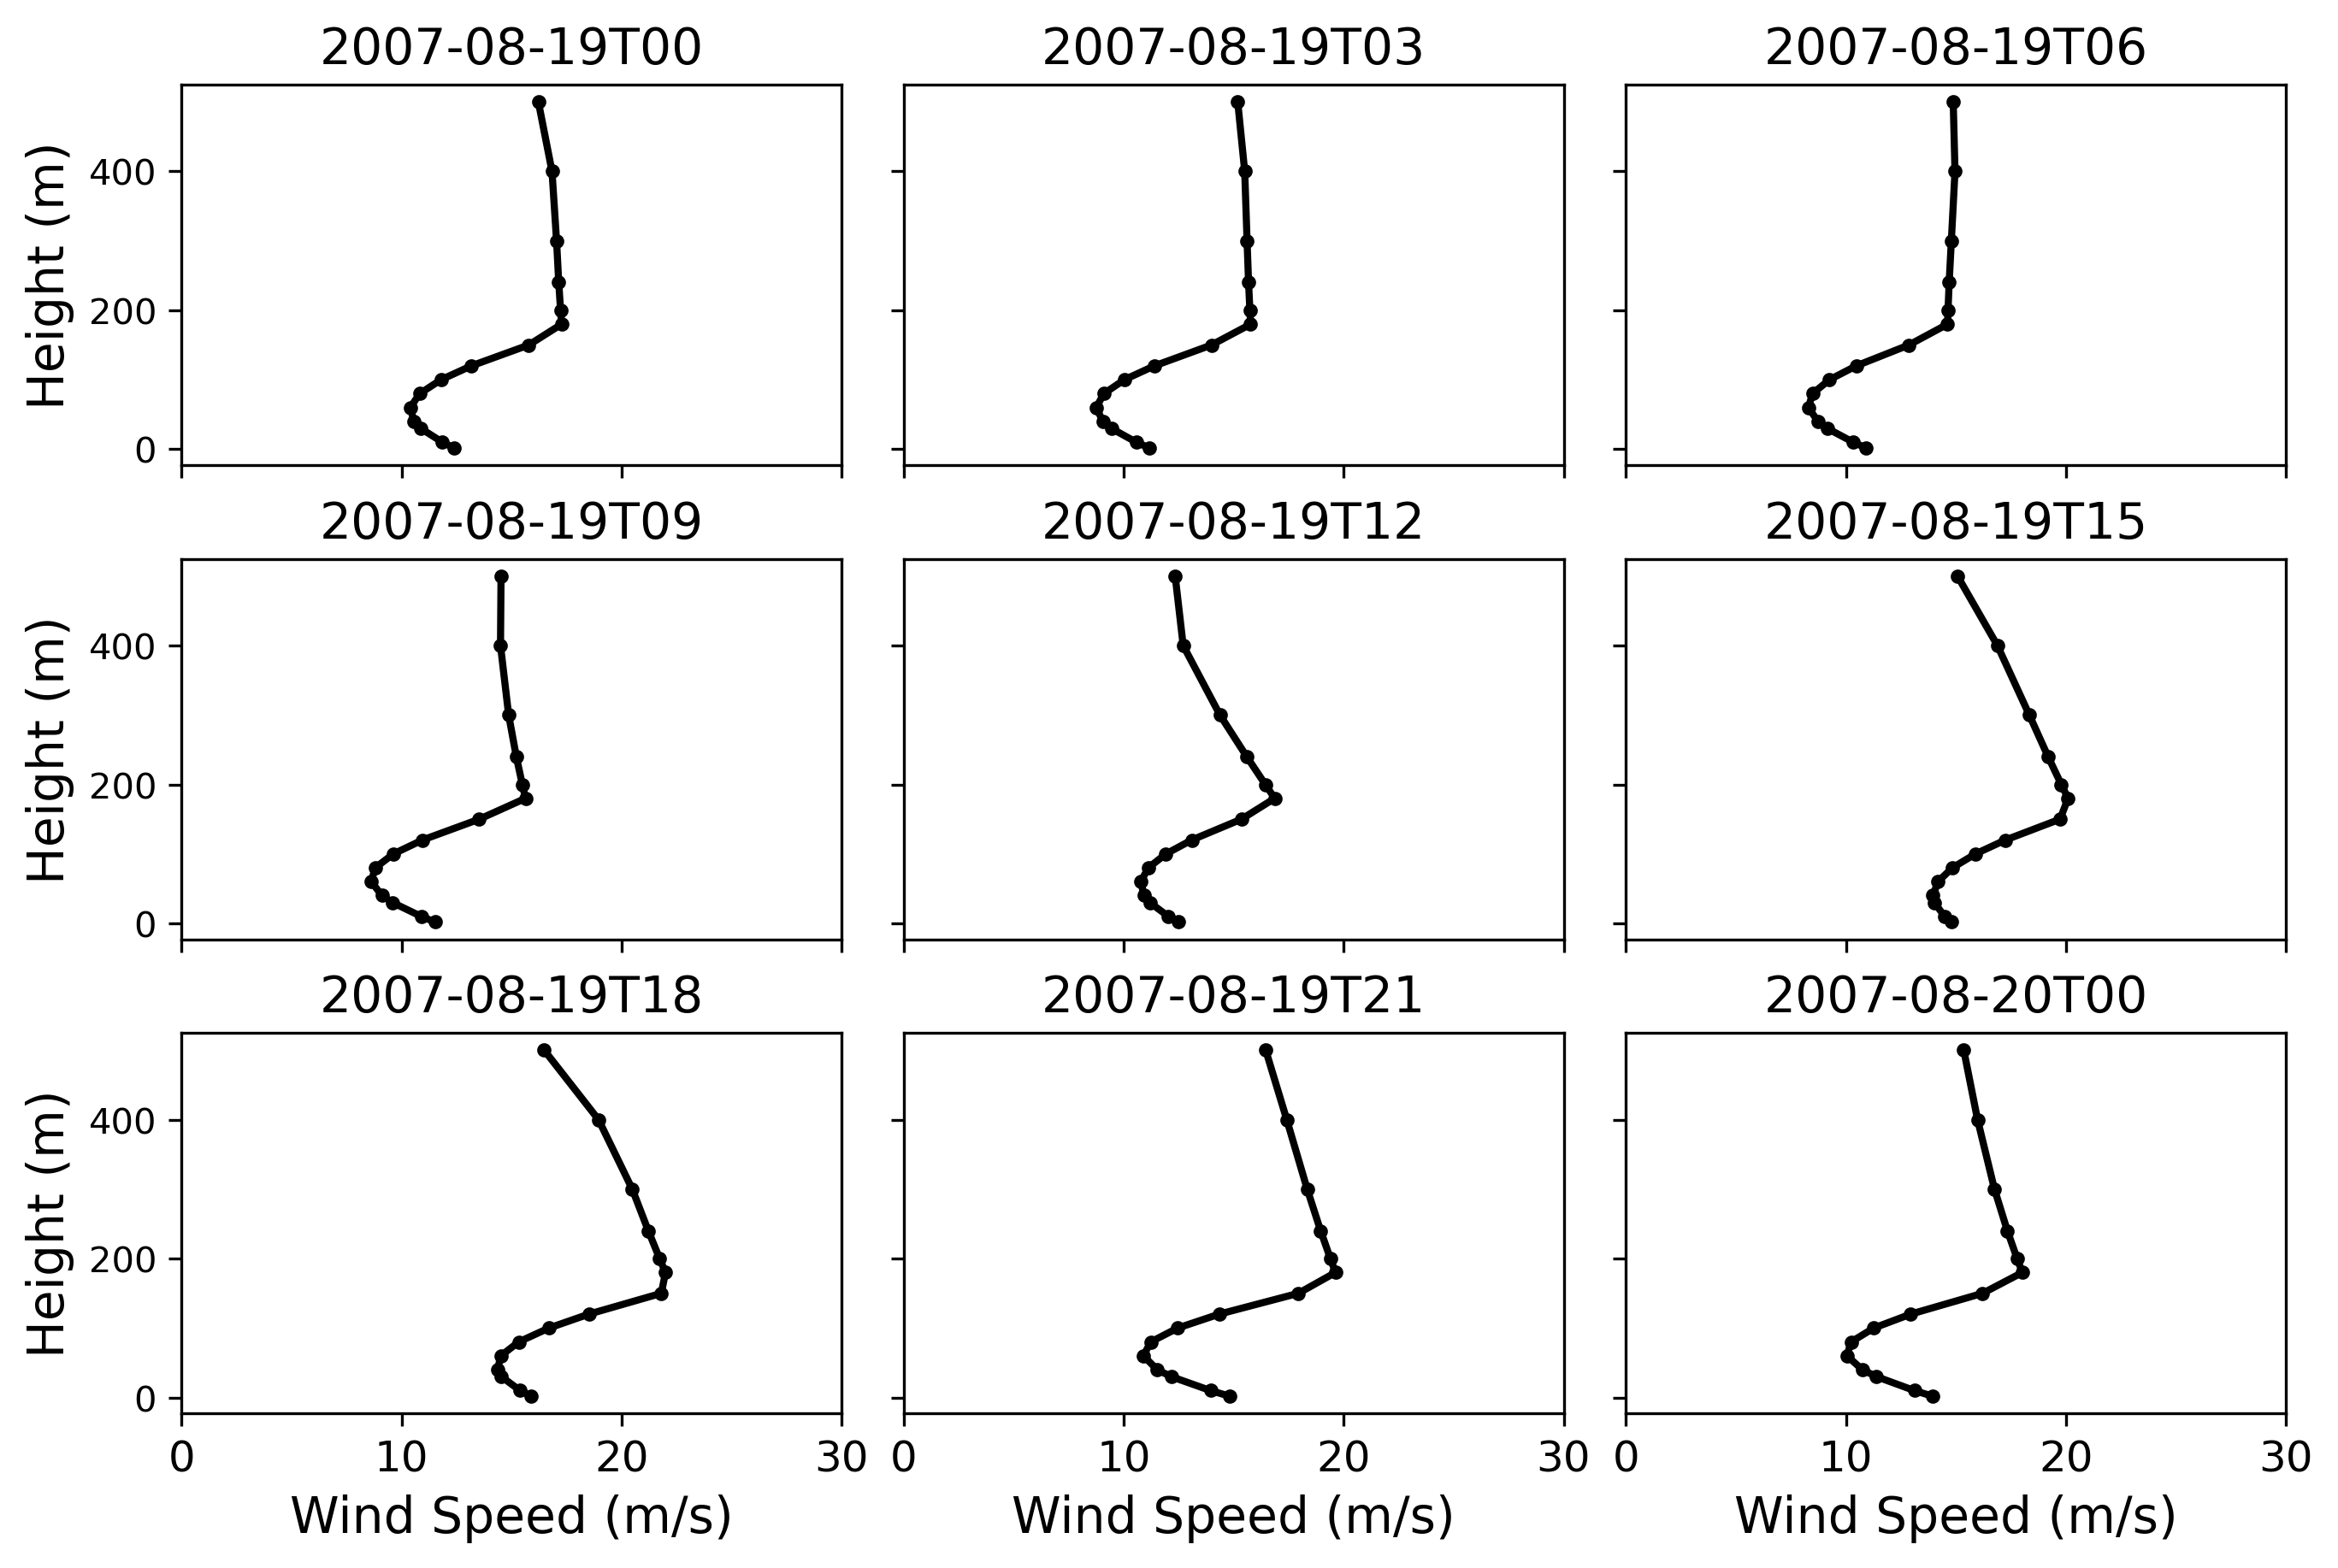

In [96]:
fig, ax = plt.subplots(3,3,figsize=(9, 6), constrained_layout=True, dpi=300, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(9):
    data = wind.isel(Time=i)
    ax[i].plot(data.values, data.level,'.-k',linewidth=2)
    ax[i].set_title(f"{data.Time.values.astype('datetime64[s]').astype(datetime).strftime('%Y-%m-%dT%H')}",fontsize=14)
    ax[i].set_xlabel('Wind Speed (m/s)', fontsize=14)
    ax[i].set_ylabel('Height (m)', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].label_outer()
    ax[i].set_xlim(0,30)
#plt.savefig(f'/home/harish/Dropbox/Apps/Overleaf/Assessment of Wind Energy Resources for Portugal at Super-Scale Resolution/IPCJ_profiles.pdf')

Time elapsed for nearest point identification is 0.018799781799316406s
Time elapsed for nearest point identification is 0.014098882675170898s
Time elapsed for nearest point identification is 0.01394796371459961s
Time elapsed for nearest point identification is 0.013525724411010742s
Time elapsed for nearest point identification is 0.013281106948852539s
Time elapsed for nearest point identification is 0.014129638671875s
Time elapsed for nearest point identification is 0.013880252838134766s
Time elapsed for nearest point identification is 0.013753414154052734s
Time elapsed for nearest point identification is 0.013551712036132812s
Time elapsed for nearest point identification is 0.013534784317016602s


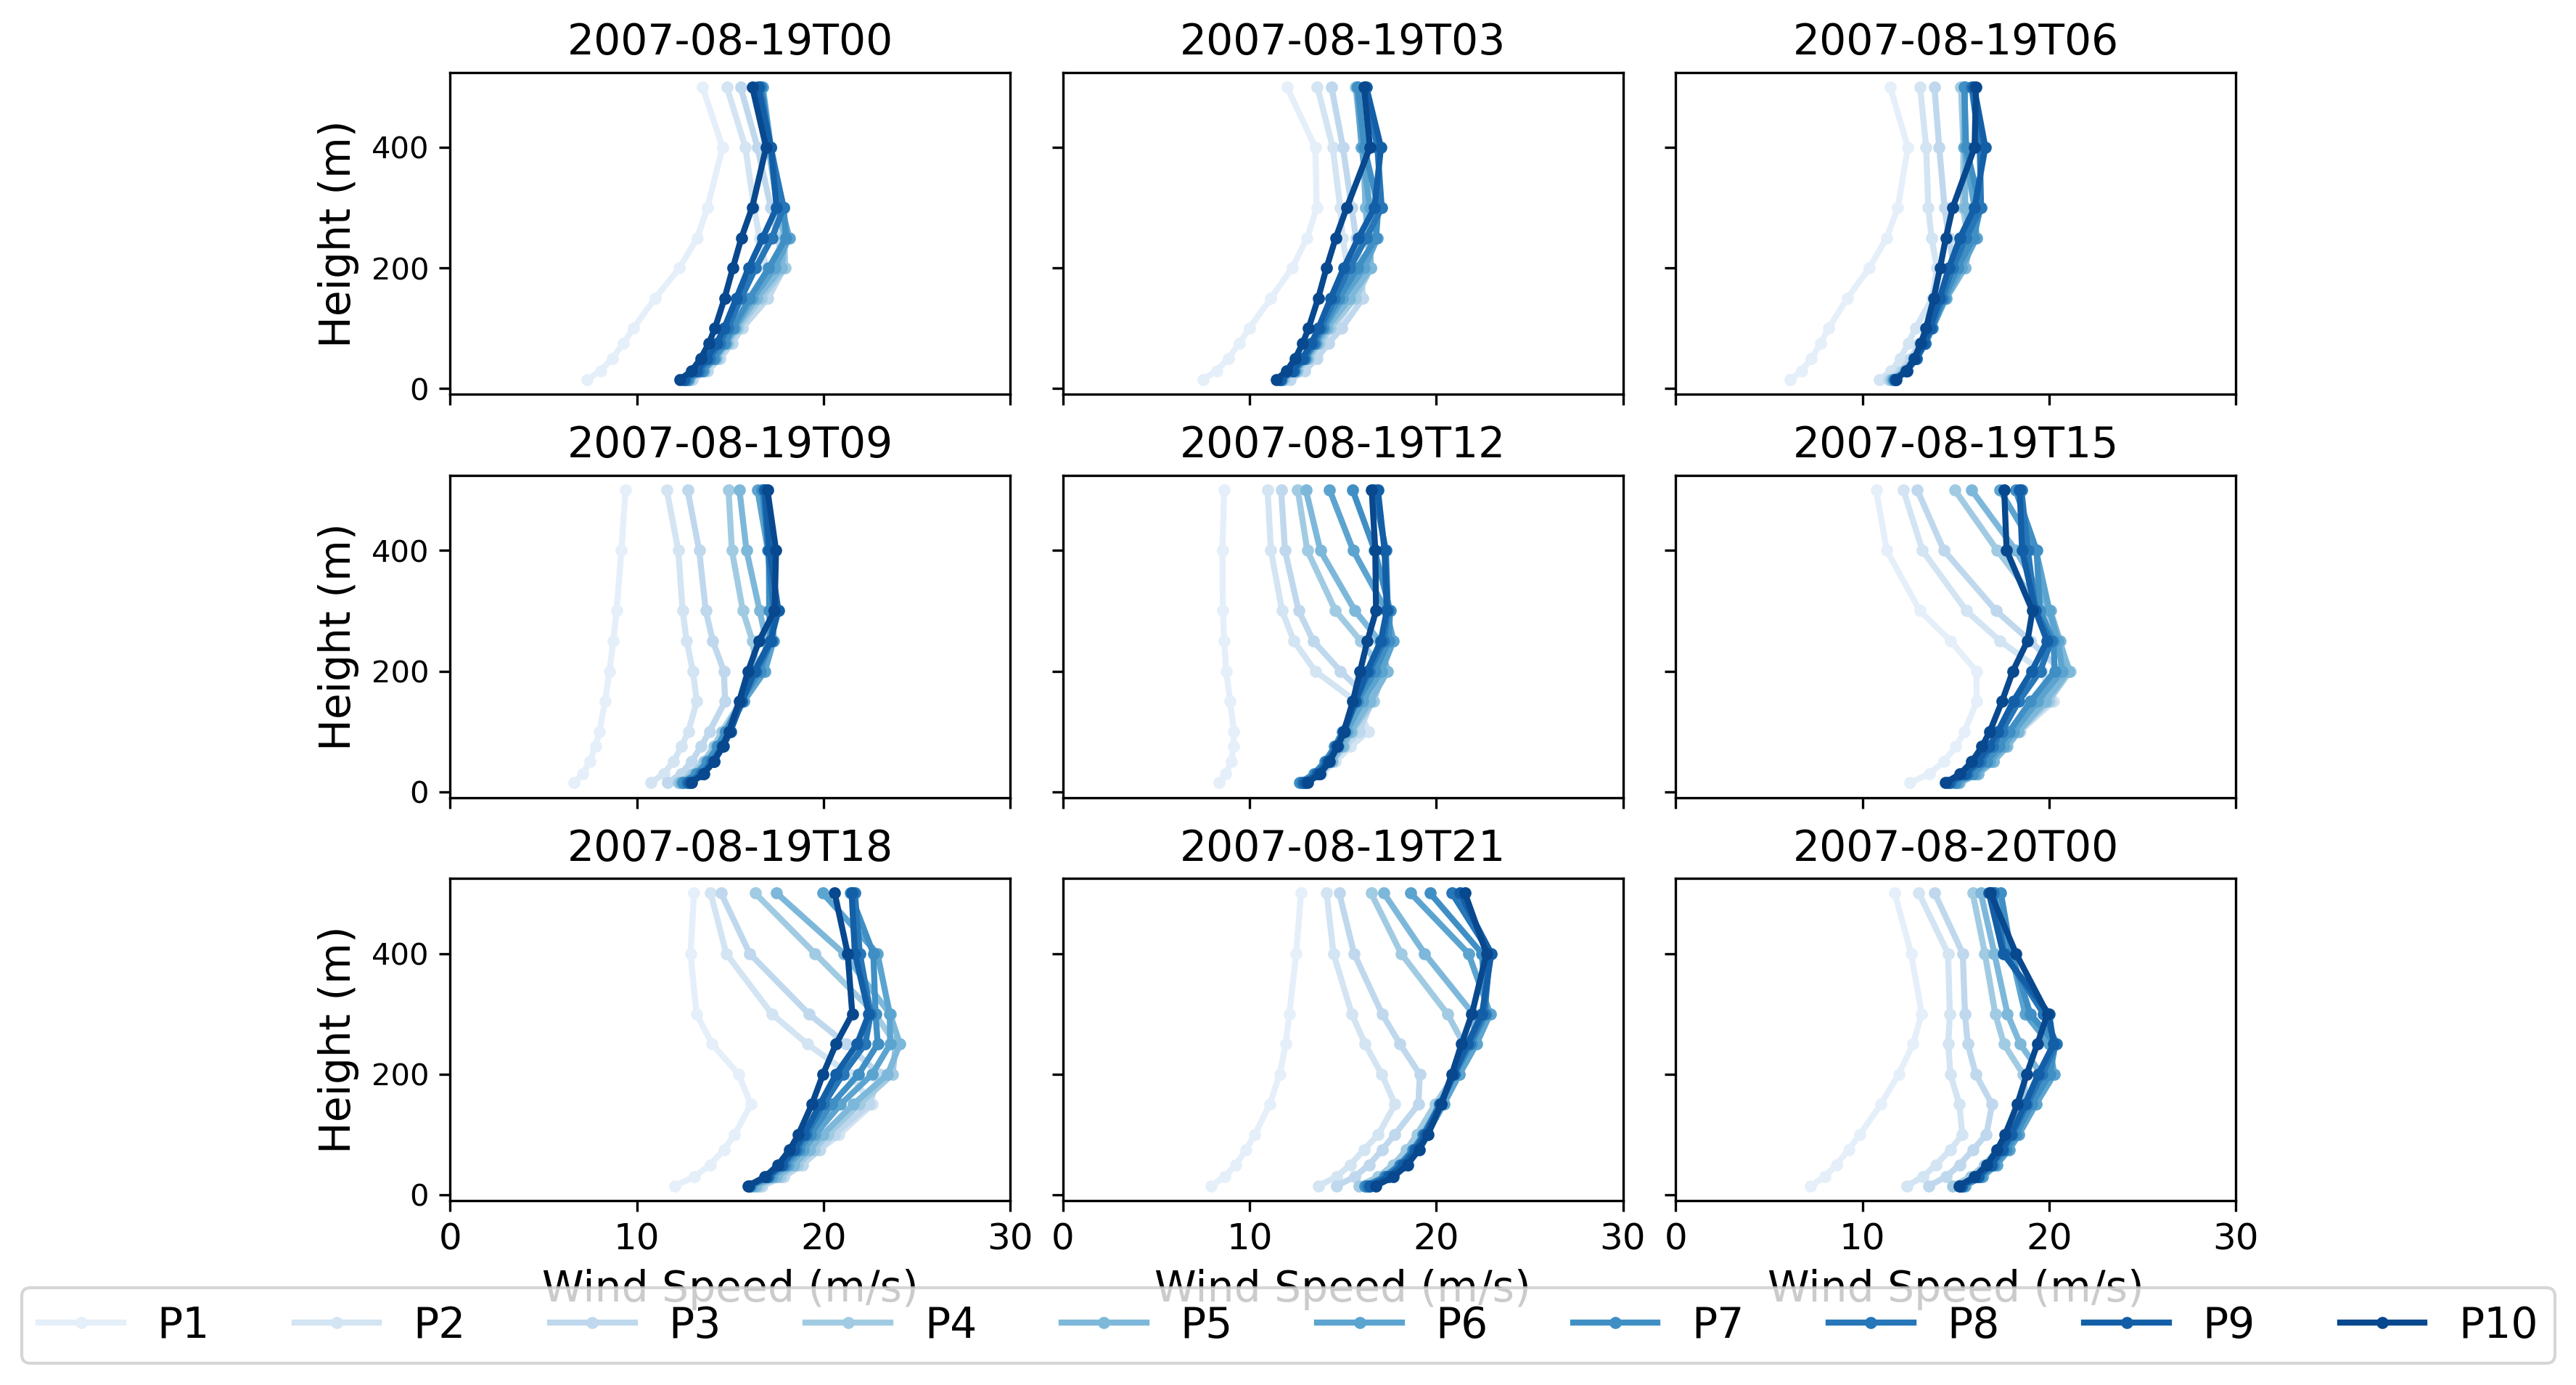

In [123]:
P1 = [41.132,-8.7]
P2 = [41.5236, -9.055]
P6 = [41.5236, -8.9]
# Create 10 locations based on P2
locations = {f'P{i+1}': (P1[0], P1[1] - 0.1 * i) for i in range(10)}
colors = sns.color_palette("Blues", 10)

CERRA = xr.open_dataset(f'{root_dir}/adaptor.mars.external-1717416871.9369903-30931-4-627944f6-236f-4fd4-8fb4-f4519a494ee8.nc')
fig, ax = plt.subplots(3,3,figsize=(9, 6), constrained_layout=True, dpi=300, sharex=True, sharey=True)
ax = ax.flatten()
for color, loc in zip(colors, locations.keys()):
    indices = nearest_indices(CERRA.latitude,CERRA.longitude,locations[loc][0], locations[loc][1])
    ws = CERRA.ws.isel(y=indices[0],x=indices[1])
    for i in range(9):
        data = ws.isel(time=i)
        ax[i].plot(data.values, data.heightAboveGround,'.-',color=color,linewidth=2,label=loc)
        ax[i].set_title(f"{data.time.values.astype('datetime64[s]').astype(datetime).strftime('%Y-%m-%dT%H')}",fontsize=14)
        ax[i].set_xlabel('Wind Speed (m/s)', fontsize=14)
        ax[i].set_ylabel('Height (m)', fontsize=14)
        ax[i].tick_params(axis='x', labelsize=12)
        ax[i].label_outer()
        ax[i].set_xlim(0,30)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,-0.05),fontsize=14)
    #plt.savefig(f'/home/harish/Dropbox/Apps/Overleaf/Assessment of Wind Energy Resources for Portugal at Super-Scale Resolution/IPCJ_profiles.pdf')

In [129]:
CERRA = xr.open_dataset(f'{root_dir}/adaptor.mars.external-1717416871.9369903-30931-4-627944f6-236f-4fd4-8fb4-f4519a494ee8.nc')

In [130]:
CERRA

<xarray.Dataset>
Dimensions:            (time: 24, heightAboveGround: 11, y: 1069, x: 1069)
Coordinates:
  * time               (time) datetime64[ns] 2007-08-19 ... 2007-08-21T21:00:00
    step               timedelta64[ns] ...
  * heightAboveGround  (heightAboveGround) float64 15.0 30.0 ... 400.0 500.0
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         (time) datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    ws                 (time, heightAboveGround, y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Norrkoping
    history:                 2024-06-03T12:14 GRIB to CDM+CF via cfgrib-0.9.9...